# GPS Walkthrough 1 --- Overview

This article is step 1 of the [GPS walkthrough series](index.qmd). Here we give an overview over the whole post series and introduce every step required to get from a raw GPS signal to a position fix. The main results are shown while detailed analysis and explanations are following in later posts.


## 1 Introduction

In this post series we investigate the GPS L1 C/A, the legacy signal with its coarse acquisition code sent by all GPS satellites in operation.

We will rely in the following to an external python module developed for this series, the `gps_walkthrough` module. Open the collapsed code sections below to get to know how it is used an how its outputs are processed. Check the [module source code](https://github.com/mu2718/gps-walkthrough/) if you want deeper insights into the  details of the processing steps before the more detailed blog articles appear. See also the [references](#sec-refs) section below for a list of sources where I have the information collected from.

To compute the following steps for yourself online, [open it in Google Colab](https://colab.research.google.com/github/mu2718/gps-walkthrough/). You can even feed it your own recorded GPS radio wave to play with the satellite signal and determine your location.

Now enjoy the journey!

In [1]:
#| code-fold: show
import gps_walkthrough as gpswt  # see https://github.com/mu2718/gps-walkthrough/

# the only other packages we will rely on:
import numpy as np
import matplotlib.pyplot as plt

## 2 Recording Radio Wave

An active GPS antenna picks up the electromagnetic (EM) wave sent by a satellite (or 'space vehicle' in GPS lingo) and feeds it to an integrated signal amplifier and filter. Its output signal is directly proportional to the incoming EM wave at any time. This output is wired up with a software-defined radio (SDR) receiver. This device is able to select a frequency-band and digitize it. Using this setup, we get an unprocessed, digital representation of the incoming GPS signal.

I am using the [HackRF](https://greatscottgadgets.com/hackrf/one/) SDR, a signal generator from Siglent delivering a high-accuracy clock to the SDR, and the u-blox ANN-MB GPS antenna.

:::{.callout-tip collapse=true }
## Analyze your own GPS radio wave?

For recording the GPS radio wave, have the following equipment ready:

- **SDR receiver** (e.g. HackRF or RTL-based) capable to receive at 1575 MHz. No precise clock reference as I use here is required.
- **Active GPS antenna** for the L1 band with at least 20dB gain. A cheap 10$ one is sufficient (e.g. MikroTik ACGPSA).
- **Bias tee voltage supply** if the SDR does not support powering the antenna. This is not required for HackRF with antennas accepting 3.3 Volts.

Alternatively, a synthetic recording can be generated using [`gps-sdr-sim`](https://github.com/osqzss/gps-sdr-sim). 

Wait for the walkthrough step 2 to get more detailed instructions...
:::

With the following command, the HackRF records the [GPS L1 signal](https://gssc.esa.int/navipedia/index.php/GPS_Signal_Plan#GPS_L1_Band) at 1575.42 MHz with appropriate [settings](https://hackrf.readthedocs.io/en/latest/hackrf_tools.html?highlight=hackrf_transfer#hackrf-tools) for amplifiers and sampling rate of 4 MHz:
```bash
$ hackrf_transfer -r wave.dat -f 1575420000 -p 1 -a 1 -l 40 -g 40 -s 4000000
```

The specified file contains the recorded, raw [in-phase and quadrature components (IQ)](https://en.wikipedia.org/wiki/In-phase_and_quadrature_components) of the EM wave amplitude.
We can read in this wave file and visualize a snippet of it in @fig-recording.

Wave recording read. Duration: 84.26 s


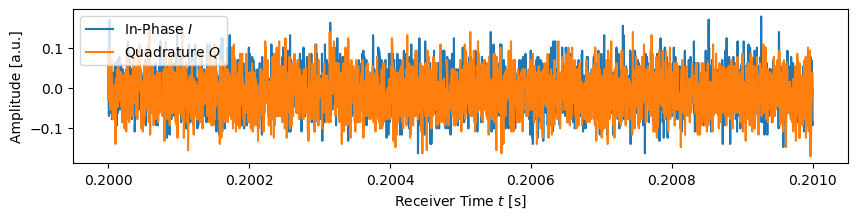

In [2]:
#| fig-cap: "Snippet of 1 ms of the recorded radio wave baseband signal with its in-phase and quadrature amplitudes."
#| label: fig-recording

sampling_rate = 4e6  # 4 MHz sampling rate of recording

# read in the recorded radio wave file (change dtype='byte' for data from `hackrf_transfer`)
baseband = gpswt.SdrWave.from_raw_file('./wave.dat', sampling_rate=sampling_rate, 
                                       #, max_samples=100000000)  # limit samples for fast experiments
                                       dtype='float32') 
# cut the first 0.1 seconds during antenna power up
baseband = baseband.get_interval(from_time=0.1)
print(f'Wave recording read. Duration: {baseband.duration():0.2f} s')

# visualize a snippet 
t0 = 0.2   # select start time
dt = 1e-3  # time window of 1ms

signal_slice = baseband.get_interval(from_time=t0, to_time=t0+dt)
t = np.linspace(t0, t0+dt, len(signal_slice.samples))

plt.figure(figsize=(10,2))
plt.plot(t, np.real(signal_slice.samples),'-', label='In-Phase $I$')
plt.plot(t, np.imag(signal_slice.samples),'-', label='Quadrature $Q$')
plt.xlabel('Receiver Time $t$ [s]')
plt.ylabel('Amplitude [a.u.]')
plt.legend()
plt.show()

If you want to get more detailed instructions for recording the GPS signal, understand EM waves and SDRs, IQ components and how they can be processed using NumPy, wait for the walkthrough step 2 to get posted. In the meantime, have a look into the source code of the [SdrWave class](https://github.com/mu2718/gps-walkthrough/blob/main/gps_walkthrough/sdr_wave.py).

## 3 Signal Acquisition

Having the radio wave recorded, we can look for a satellite signal. Those of us having experience with pre-internet radio know: Tuning-in on a channel means essentially turning one knob to set the frequency right (and sometimes redirecting and stretching the antenna). GPS L1 C/A is not much different, but we have four knobs which have to be set, the demodulation parameters:

Frequency Shift
: GPS L1 satellites send on a carrier frequency of 1575.42 MHz with very high accuracy. But due the satellites high speeds of up to 4000 m/s relative to us, the [Doppler effect](https://en.wikipedia.org/wiki/Doppler_effect) physically shifts the received frequency up to $\pm 5000$ Hz. Despite its relatively small magnitude, the Doppler shift has to be compensated for signal reception. Note that changes in velocity of the satellite relative to the receiver (e.g. in a fly-over) results in changes of this parameter over time and thereby need to be readjusted constantly. <br/>
An *inaccurate receiver clock*, i.e. the clock built into the SDR receiver, is an additional source of frequency shift: As we base all our measurement on it, a too slow clock will show up as too high frequencies in the recording and vice versa. Since I use an external high-accuracy clock, the frequency shift can be fully attributed to the Doppler effect in the following.

PRN number (C/A Code)
: All satellites send on the same frequency. Using a [code-division multiple access](https://en.wikipedia.org/wiki/Code-division_multiple_access) (CDMA) method, where each satellite sends its own code, we can distinguish EM wave contributions from different senders. These code sequences are called *C/A codes* and are identified by their pseudo-random noise or *PRN numbers*, ranging from 1 to 37. The PRN number has therefore to be set to select a specific satellite to listen to.

Code Delay
: The C/A code sequence of a satellite can only be detected if we know its time of reception to within a microsecond. The *code delay* is defined by the time the code is sent, as expected based on the receiver's own inaccurate clock, and the actually observed time of reception. Note that changes in distance between the receiver and a satellite modifies this value by 1 $\mu s$ per 300 meters distance. Since satellites travel at up to 4000 m/s, we need to constantly readjust the delay to maintain reception.

Carrier Phase Angle
: GPS L1 satellites send telemetry data (GPS time, orbital parameters, ...). It is transmitted in the EM wave using the [binary phase-shift keying](https://en.wikipedia.org/wiki/Phase-shift_keying#Binary_phase-shift_keying_(BPSK)) (BPSK) modulation technique. In order to demodulate this information, we need to distinguish between the sine and cosine contributions of the carrier frequency, i.e. the *phase angle* of the received wave. Note that changes in distance to a satellite or atmospheric conditions modify the phase over time.

The GPS signal *acquisition* procedure tries to find the value of these parameters for optimal signal reception by going through all combinations of parameters settings and picking the optimal one.


### First Signal Detection

For the very first millisecond of our radio wave recording, let's try to find the signal sent by the satellite which emits the C/A code PRN 16 by performing the acquisition:

In [3]:
acq = gpswt.Acquisition(prn_id=16, sampling_dt=baseband.sampling_dt)  # look for PRN 16, I know it is there :) 
acq_data = acq.search(baseband.get_interval(to_time=0.001),           # look at first 1 ms = 1 C/A code period
                      delta_freq_range=(-5000, 5000),                 # increase to 100k for HackRF w/o external clock
                      delta_freq_step=10)[-1]                         # fine-grained Doppler steps 

print(f"Signal Power:  {np.abs(acq_data['correlator'])**2 * 100:.2f} % of total")
print(f"Doppler Shift: {acq_data['delta_freq']} Hz")
print(f"Code Delay:    {acq_data['delay'] * 1e6} microseconds")
print(f"Carrier Phase: {np.angle(acq_data['correlator']):.2f} radians")

Signal Power:  1.69 % of total
Doppler Shift: -2830.0 Hz
Code Delay:    13.0 microseconds
Carrier Phase: 1.04 radians


These are the optimal demodulation parameter settings the acquisition procedure has found. Some observations we can make already:

- Despite that the satellite's signal power is below 2% of the total power that the SDR records, we can isolate it and distinguish it from noise and other satellites.
- A negative Doppler shift means that the received frequency is lower than it was sent by the satellite. As we know it from everyday acoustic experiences, we can infer that this satellite is heading away from us. We will confirm this later on.

The scanning on Doppler shift and code delay performed during acquisition is shown in @fig-acq-scan.  We can observe that a discrepancy of only 1 $\mu s$ of in code delay and 1000 Hz in frequency shift results in total loss of the signal. This distinct signature of the peak indicates that our demodulation works and that we have detected a signal sent by a satellite!!

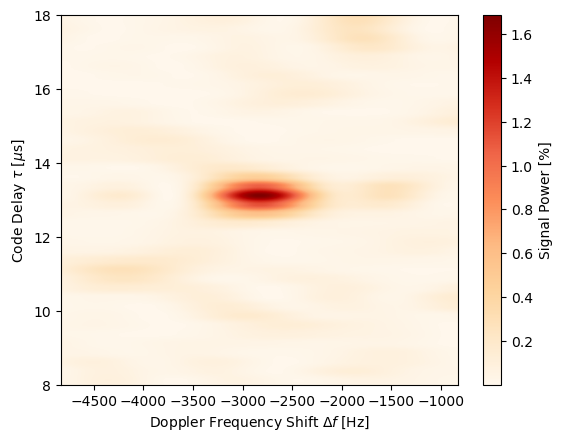

In [4]:
#| fig-cap: "Received signal power of one satellite under different demodulation parameters. The full acquisition search region is zoomed in on the peak power."
#| label: fig-acq-scan

plt.subplot()
plt.imshow(acq._scan_data * 100, 
           extent=(-5000,5000, 0, 1000),  # scan parameter space
           cmap='OrRd', origin='lower', aspect='auto')
# center on global maximum
plt.ylim([acq_data['delay']*1e6 - 5, acq_data['delay']*1e6 + 5])
plt.xlim([acq_data['delta_freq'] - 2000, acq_data['delta_freq'] + 2000])

plt.xlabel('Doppler Frequency Shift $\Delta f$ [Hz]')
plt.ylabel('Code Delay $\\tau$ [$\\mu$s]')
plt.colorbar(label='Signal Power [%]')
plt.show()

### Search Satellites

We can search for all satellites in the first few milliseconds of our signal using the acquisition procedure, see @fig-acq-all. Since we expect to see only a handful of satellites, we have to conclude that a the noise floor of around 0.5% power is present in all PRNs: We get spurious signals not originating from senders but noise on all PRNs. 

Five satellites can be identified that send well above the noise floor. Since at least 4 satellites are required for a position fix, we can proceed.

Top-5 PRNs: [21 16 27  1 32]


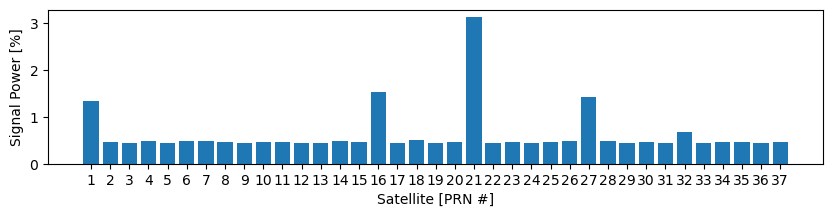

In [5]:
#| fig-cap: "Received signal power on all 37 C/A codes identified by their PRN number during first 50 ms of the recording."
#| label: fig-acq-all

prn_ids = range(1, 38)  # PRN IDs to search for

signal_strength = np.zeros(len(prn_ids))
for i, prn_id in enumerate(prn_ids):
    signal_slice = baseband.get_interval(to_time=0.05)  # take first 50 ms

    acq = gpswt.Acquisition(prn_id, sampling_dt=baseband.sampling_dt)
    acq_data = acq.search(signal_slice,
                          delta_freq_step=500, 
                          delta_freq_range=(-5000,5000)) # increase to 100k for HackRF w/o external clock
    
    signal_strength[i] = np.median(np.abs(acq_data['correlator']**2))  # average power

best_prns = np.argsort(-signal_strength)[:5] + 1
print(f'Top-5 PRNs: {best_prns}')

plt.subplots(figsize=(10,2))
plt.bar(prn_ids, signal_strength * 100, tick_label=prn_ids)
plt.xlabel('Satellite [PRN #]')
plt.ylabel('Signal Power [%]')
plt.show()

If you want to know more about C/A codes, how we detect it in the recording, what the four demodulation parameters exactly mean and how we have to search for them, then wait for walkthrough step 3 to be posted... In the meantime, have a look into the source code of the [acquisition](https://github.com/mu2718/gps-walkthrough/blob/main/gps_walkthrough/acquisition.py) and [C/A code module](https://github.com/mu2718/gps-walkthrough/blob/main/gps_walkthrough/gps_ca_code.py).

## 4 Signal Tracking and Demodulation

In order to maintain reception over the time of the recording, we constantly need to readjust to modulation parameters for each satellite. As shown in @fig-tracking-disabled-dll, the satellite's signal is lost in a fraction of a second if not done so.

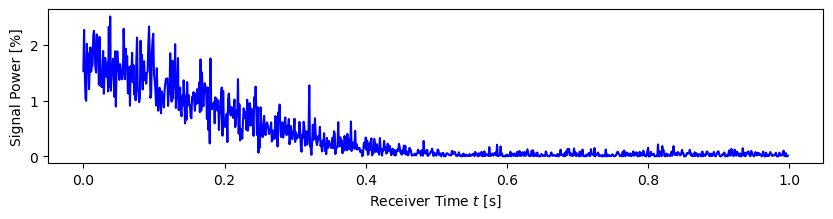

In [6]:
#| fig-cap: "Signal power with a fixed code delay parameter for CDMA demodulation. We lose the signal within a fraction of a second."
#| label: fig-tracking-disabled-dll

# get initial doppler shift and code delay parameters using acquisition procedure
acq = gpswt.Acquisition(prn_id=16, sampling_dt=baseband.sampling_dt)
acq_data = acq.search(baseband.get_interval(to_time=0.005))  # first periods only
delta_freq_start = np.median(acq_data['delta_freq'])
delay_start = np.median(acq_data['delay'])

# tracking with disabled delay-locked loop (DLL)
tracker = gpswt.Tracking(prn_id=16, sampling_dt=baseband.sampling_dt, 
                         dll_guided=False, dll_ki=0.0,  # disable DLL               
                         delta_freq_start=delta_freq_start,
                         delay_start=delay_start)
tracking_data = tracker.track(baseband.get_interval(to_time=1.0))

amplitudes = tracking_data['correlator']
t = tracking_data['time_code_start']

fig, ax = plt.subplots(figsize=(10, 2.*1))
ax.plot(t, abs(amplitudes)**2 * 100, 'b')
ax.set_xlabel('Receiver Time $t$ [s]') 
ax.set_ylabel('Signal Power [%]')
plt.show()

Constant readjustment could be performed with the acquisition procedure shown above, by blindly searching the optimal parameters for every millisecond of the signal individually. But there are some major drawbacks using this approach. 

Exploiting the fact that the parameters change continuously, we can keep them optimized using [control loops](https://en.wikipedia.org/wiki/Control_loop): One loop locking on the frequency, one on the code delay, and one on the phase. This procedure is called *tracking* of the signal and has several advantages compared to the acquisition algorithm: It is much faster since it does not start search blindly from scratch, yields more accurate parameter values, and is more robust to noise.

The result of tracking is a

- high-precision code delay value (for our analysis here we achieve less than 10 nanoseconds) for accurate time-of-flight estimation, and
- the *[CDMA](https://en.wikipedia.org/wiki/Code-division_multiple_access)-demodulated* signal, which allows to decode the telemetry messages sent by each satellite.

Tracking of PRN 16 is shown in @fig-tracking. After a short time period at the beginning where the control loops lock-in on the optimal values, the parameters develop steadily and signal power is maintained.

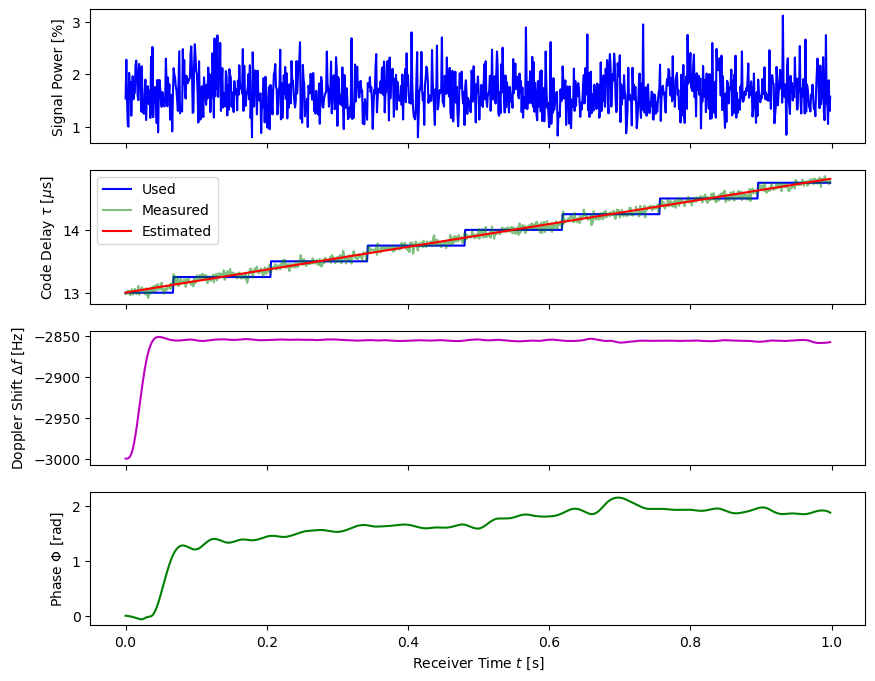

In [7]:
#| fig-cap: "Tracking of a PRN 16. Code delay, Doppler shift and phase are constantly adjusted to maintain signal reception."
#| label: fig-tracking

# get initial doppler shift and code delay parameters using acquisition procedure
acq = gpswt.Acquisition(prn_id=16, sampling_dt=baseband.sampling_dt)
acq_data = acq.search(baseband.get_interval(to_time=0.005))  # first periods only
delta_freq_start = np.median(acq_data['delta_freq'])
delay_start = np.median(acq_data['delay'])

tracker = gpswt.Tracking(prn_id=16, sampling_dt=baseband.sampling_dt,
                         delta_freq_start=delta_freq_start,
                         delay_start=delay_start)
tracking_data = tracker.track(baseband.get_interval(to_time=1.0))

amplitudes = tracking_data['correlator']
t = tracking_data['time_code_start']

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 2.*4))
ax[-1].set_xlabel('Receiver Time $t$ [s]') 

ax[0].plot(t, abs(amplitudes)**2 * 100, 'b')
ax[0].set_ylabel('Signal Power [%]')

ax[1].set_ylabel('Code Delay $\\tau$ [$\mu$s]')
ax[1].plot(t, tracking_data['delay_used'] * 1e6, 'b', label='Used')
ax[1].plot(t, (tracking_data['delay_used'] + tracking_data['discriminator_tau']) * 1e6,
           'g', label='Measured', alpha=0.5)
ax[1].plot(t, tracking_data['delay'] * 1e6, 'r', label='Estimated')
ax[1].legend()    

ax[2].plot(t, tracking_data['delta_freq'], 'm')
ax[2].set_ylabel('Doppler Shift $\Delta f$ [Hz]')
    
ax[3].plot(t, tracking_data['phi'], 'g')
ax[3].set_ylabel('Phase $\Phi$ [rad]')
plt.show()

Over the shown time period, the code delay needs to be increased constantly. Equally as for the negative Doppler shift frequency, this is a consequence of the fact that this satellite is heading away from us and its distance is thereby increasing, i.e. its signal arrives more and more delayed over time. Over the shown time period of 1s, we observe an increase of approx. 1.5$\mu$s in delay. Multiplied by the speed of light, this corresponds to a speed of roughly 450 m/s. (Notice, that this value does not reflect the satellite's speed, but only to its component along the line of sight from us.)

### BPSK Demodulation

Each GPS L1 satellite sends navigation messages (LNAV) which contains the telemetry data. These messages are modulated onto the CDMA signal using [binary phase-shift keying (BPSK)](https://en.wikipedia.org/wiki/Phase-shift_keying#Binary_phase-shift_keying_(BPSK)). We see in @fig-signal-demodulated, after the lock-in phase of the tracking, that a clean digital signal can be observed. Obviously, the BPSK demodulation yielding the binary information is straightforward.

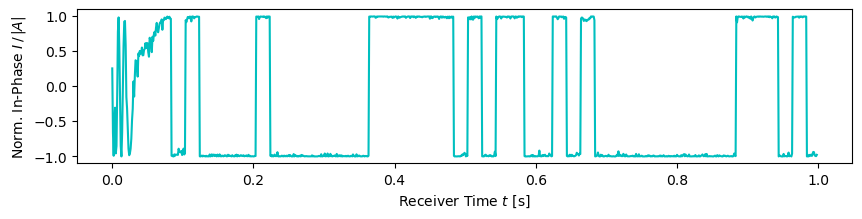

In [8]:
#| fig-cap: "CDMA-Demodulated telemetry signal of a satellite."
#| label: fig-signal-demodulated

fig, ax = plt.subplots(figsize=(10, 2.))
ax.plot(t, np.real(amplitudes) / np.abs(amplitudes), 'c')
ax.set_ylabel('Norm. In-Phase $I \, / \, |A| $')
ax.set_xlabel('Receiver Time $t$ [s]')

plt.show()

A different method allowing to visualize digital modulation of a signal over longer time periods are [constellation diagrams](https://en.wikipedia.org/wiki/Constellation_diagram). In @fig-signal-constellation, we observe that later CDMA demodulated samples (blue, green, yellow), where signal tracking locked after startup (purple), fall into two well distinguishable spots. These are the two states encoding a bit in the BPSK scheme. That means that the signal tracking and CDMA demodulation is reliable over the first 10s, and BPSK demodulation will work flawlessly.

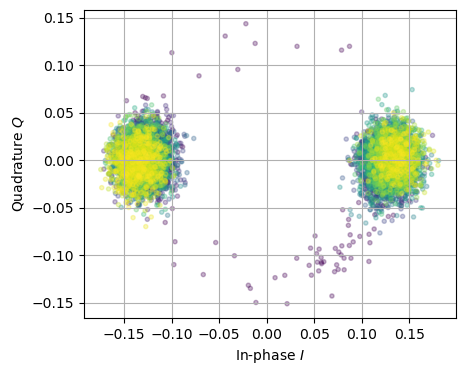

In [9]:
#| fig-cap: "Constellation diagram of CDMA-demodulated signal during the first 10 seconds. Color indicates reception time from start (purple) to end (yellow). A point represent the IQ sample of one C/A code."
#| label: fig-signal-constellation

tracker = gpswt.Tracking(prn_id=16, sampling_dt=baseband.sampling_dt, 
                         delta_freq_start=acq_data[0]['delta_freq'],
                         delay_start=acq_data[0]['delay'])
tracking_data = tracker.track(baseband.get_interval(to_time=10))  # 10 s interval
amplitudes = tracking_data['correlator']

fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(np.real(amplitudes), np.imag(amplitudes), 
           marker='.', alpha=0.3, c=range(len(amplitudes)))
ax.set_aspect('equal', 'box')
ax.set_xlabel('In-phase $I$')
ax.set_ylabel('Quadrature $Q$')
ax.grid(which='major')
plt.show()

### Track and Demodulate All

We can now get the navigation messages being sent by performing all steps shown above for each satellite: 

1. Acquisition, to find initial demodulation parameters.
2. Tracking, to follow the parameters over long recording time and get CDMA demodulation.
3. BPSK demodulation, to get the encoded binary stream of the navigation messages.

In [10]:
print(f'Analyzing signal of length {baseband.duration():.1f} s:')
pseudo_symbols = {}
tracking_data = {}
for prn_id in best_prns:
    print(f'PRN {prn_id}:', end='')

    print('  Acquisition... ', end='')
    acq = gpswt.Acquisition(prn_id, sampling_dt=baseband.sampling_dt)
    acq_data = acq.search(baseband.get_interval(to_time=0.05))  # check first 50ms = 50 code periods

    delta_freq_start = np.median(acq_data['delta_freq'])
    delay_start = np.median(acq_data['delay'])

    print(f'  Tracking... ', end='')
    tracker = gpswt.Tracking(prn_id, sampling_dt=baseband.sampling_dt,
                             delta_freq_start=delta_freq_start,
                             delay_start=delay_start)
    tracking_data[prn_id] = tracker.track(baseband, progress=False)  # track full signal length

    print(f'  BPSK Demodulation... done.')
    pseudo_symbols[prn_id] = \
        np.real(tracking_data[prn_id]['correlator']) > 0  # distinguish between 0 and 1

Analyzing signal of length 84.3 s:
PRN 21:  Acquisition...   Tracking...   BPSK Demodulation... done.
PRN 16:  Acquisition...   Tracking...   BPSK Demodulation... done.
PRN 27:  Acquisition...   Tracking...   BPSK Demodulation... done.
PRN 1:  Acquisition...   Tracking...   BPSK Demodulation... done.
PRN 32:  Acquisition...   Tracking...   BPSK Demodulation... done.


This is rather lengthy calculation, taking almost 10 minutes on my laptop for the given length of the recording. Certainly, the algorithm's are not at all optimized for speed, but are roughly 20 times faster than the acquisition procedure is.

If you want to know more about control loops, signal processing, demodulation, wait for the walkthrough step 4 to be published. In the meantime, have a look into the source code of the [tracking module](https://github.com/mu2718/gps-walkthrough/blob/main/gps_walkthrough/tracking.py).

In [11]:
# to avoid running tracking again, save the output for later experimentation...

#import pickle
# if pseudo_symbols and tracking_data:  # save the data if present
#     with open('psymbols.pickle', 'wb') as f:
#         pickle.dump(pseudo_symbols, f)
#     with open('trackdata.pickle', 'wb') as f:
#         pickle.dump(tracking_data, f)

# with open('psymbols.pickle', 'rb') as f:  # load it from file if available
#     pseudo_symbols = pickle.load(f)
# with open('trackdata.pickle', 'rb') as f:
#     tracking_data = pickle.load(f)
# best_prns = list(pseudo_symbols.keys())

## 5 Telemetry Decoding

The telemetry data sent in navigation messages by all satellites contain information about their orbital parameters as well as clock error information of the on-board atomic clocks. Both are required for calculating a satellite's position very accurately at every moment in time.

The BPSK demodulation done above yields a binary stream. Its constituents are called *pseudo-symbols*. The actual information carrying bits, used for encoding the telemetry message, consist of 20 identically repeated pseudo-symbols. Messages sent by the satellite are encoded in a data structure called which consists of give *subframes*. To get the frame data, we have to perform the following steps:

- Bit synchronization: Find out where in the stream of pseudo-symbols a bit starts.
- Bit decoding: Decode the pseudo-symbols and generate the stream of bits.
- Frame synchronization: Find the start of a frame in the stream of bits.
- Frame dissection: Read the frame data structure, check its validity using checksums, and represent it in a usable form.

Let's do that for all satellites:

In [12]:
telemetry = {}
for prn_id in best_prns:
    print(f'PRN {prn_id}')
    
    bits, bit_start_symbol = gpswt.telemetry.bit_synchronize(pseudo_symbols[prn_id])
    bits, subframe_start_bit = gpswt.telemetry.subframe_synchronize(bits)
    telemetry_data = gpswt.telemetry.subframe_dissect(bits, subframe_start_bit, bit_start_symbol)
    
    telemetry[prn_id] = telemetry_data
    print()

PRN 21
Bits: synced, avg. pseudo-symbol errors per bit: 0.002
Subframes: synced, found 14, valid 13
Dissection: 13 subframes decoded.

PRN 16
Bits: synced, avg. pseudo-symbol errors per bit: 0.003
Subframes: synced, found 14, valid 13
Dissection: 13 subframes decoded.

PRN 27
Bits: synced, avg. pseudo-symbol errors per bit: 0.001
Subframes: synced, found 14, valid 13
Dissection: 13 subframes decoded.

PRN 1
Bits: synced, avg. pseudo-symbol errors per bit: 0.002
Subframes: synced, found 14, valid 13
Dissection: 13 subframes decoded.

PRN 32
Bits: synced, avg. pseudo-symbol errors per bit: 0.004
Subframes: synced, found 14, valid 13
Dissection: 13 subframes decoded.



We see from the output that the telemetry data of all five satellites was successfully decoded. While a few pseudo-symbols are reported to be faulty, the signal quality was good enough that almost all subframes were valid, i.e. contain no bit errors.

Let's have a look at the telemetry data of one of the satellites. The first five received subframes read

In [13]:
for i in range(5):  # show a full frame = 5 subframes
    print(telemetry[16][i])

{'start_symbol': 3964, 'subframe_id': 1, 'integrity': 0, 'time_of_week': 52116, 'clock': {'week_number': 213, 'sv_health': 0, 'T_GD': -1.0244548320770264e-08, 't_oc': 57600, 'a_f2': 0.0, 'a_f1': 3.183231456205249e-12, 'a_f0': -0.0005030031315982342}}
{'start_symbol': 9964, 'subframe_id': 2, 'integrity': 0, 'time_of_week': 52122, 'ephemeris': {'C_rs': 131.75, 'dn': 4.2019607428169266e-09, 'M_0': -3.0335492879613675, 'C_uc': 1.642853021621704e-06, 'e': 0.01333794859237969, 'C_us': 9.84780490398407e-06, 'sqrtA': 5153.60133934021, 't_oe': 57600}}
{'start_symbol': 15964, 'subframe_id': 3, 'integrity': 0, 'time_of_week': 52128, 'ephemeris': {'C_ic': -9.313225746154785e-09, 'Omega_0': 0.6220877159703716, 'C_is': -2.3096799850463867e-07, 'i_0': 0.965627893317696, 'C_rc': 192.03125, 'omega': 0.7866631281797375, 'Omega_dot': -7.618888785870861e-09, 'I_dot': 6.321691895270685e-11}}
{'start_symbol': 21964, 'subframe_id': 4, 'integrity': 0, 'time_of_week': 52134}
{'start_symbol': 27964, 'subframe_i

 The subframes data structure contains:

- `time_of_week`: exact time of sending of this subframe by the satellite in seconds, as measured by the satellite's atomic clock,
- `clock`: satellite clock correction data, since the atomic clocks need still some correction to be accurate enough for our purposes,
- `ephemeris`: parameters required to calculate the satellite orbit positions at any time,
- meta data added by the telemetry decoder (e.g. the subframe's start pseudo-symbol index, `start_symbol`, in the sequence of recorded symbols).

We can observe that a subframe is transmitted every 6 seconds (steps in `time_of_week`), and that one subframe is encoded using 6000 pseudo-symbols (steps in `start_symbol`).

If you want to know more about synchronization, decoding, dissetion and the GPS L1 navigation message data structures, wait for the walkthrough step 5 to be published. In the meantime, have a look into the source code of the [telemetry module](https://github.com/mu2718/gps-walkthrough/blob/main/gps_walkthrough/telemetry.py).

## 6 Pseudorange Measurement

In order to calculate our position, we need to perform measurements of so called [observables](https://gssc.esa.int/navipedia/index.php/GNSS_Basic_Observables). The one we will consider here is called *[pseudorange](https://en.wikipedia.org/wiki/Pseudorange)*. It represents a measurable quantity which is related to the distance between the receiver and a satellite. The pseudorange to satellite i is defined by

$$ R_i = c \, (t_{i} - T_{i}) $$

with the speed of light $c$, the receiving time $t_i$ of a signal as measured by the receiver, and the send time $T_i$ of this signal as measured by satellite i's atomic clock in [GPS time](https://en.wikipedia.org/wiki/Global_Positioning_System#Timekeeping). Therefore, measuring $t_i$ and decoding $T_i$ from the telemetry allows us to infer $R_i$.

The reason why this is not the actual range or distance: While $T_i$ is very accurate thanks to the atomic clocks and their correction information available through telemetry, the cheap receiver clock built into our SDR, on which we base our measurements of $t_r$, is not accurate at all. Furthermore, the speed of light might not correspond to the radio wave's effective speed of propagation (atmosphere's influence). These discrepancies make the pseudorange deviate from the actual, physical distance and have to be taken into account later. 

Let's have a look at pseudoranges of PRN 16 during the first few seconds:

In [14]:
pseudo_range = gpswt.observables.pseudo_ranges(telemetry[16], tracking_data[16], 
                                               observation_interval=1.0)
for k in range(4):
    print(f"t_i = {pseudo_range['receive_time'][k]:.6f} s, "
          f"T_i = {pseudo_range['send_time_gps'][k]:.6f} s, "
          f"R_i - r = {pseudo_range['pseudo_range'][k] - pseudo_range['pseudo_range'][0]:.2f} m")

t_i = 0.000000 s, T_i = 52106.036490 s, R_i - r = 0.00 m
t_i = 1.000000 s, T_i = 52107.036488 s, R_i - r = 543.89 m
t_i = 2.000000 s, T_i = 52108.036486 s, R_i - r = 1085.70 m
t_i = 3.000000 s, T_i = 52109.036485 s, R_i - r = 1626.99 m


A comparison between the receiver time $t_i$ and the send time $T_i$ reveals that they are roughly in sync, but off by almost a day. In the last shown digits of $T_i$, we can observe that the signal received at the integer values $t_i$ are sent earlier and earlier, explained by an increasing in distance and pseudorange. Its change is reported as $R_i - r$, where $r$ is a constant. We can read off a receding speed of approx. 540 m/s of the satellite (again only in line of sight).

Let's measure the pseudoranges for all satellites as we need them in our next steps.

In [15]:
position_fix_time_interval = 0.5
print(f'Measurement Time Interval: {position_fix_time_interval} s\n')

pseudo_ranges = {}
for prn in best_prns:
    print(f'Measuring pseudoranges for PRN {prn}...')
    pseudo_ranges[prn] = gpswt.observables.pseudo_ranges(telemetry[prn], tracking_data[prn], 
                                                         position_fix_time_interval)

Measurement Time Interval: 0.5 s

Measuring pseudoranges for PRN 21...
Measuring pseudoranges for PRN 16...
Measuring pseudoranges for PRN 27...
Measuring pseudoranges for PRN 1...
Measuring pseudoranges for PRN 32...


If you want to know more about the measurement of the nanosecond accurate time of reception, pseudoranges, clock corrections, then wait for the walkthrough step 6 to be published. In the meantime, have a look into the source code of the [observables module](https://github.com/mu2718/gps-walkthrough/blob/main/gps_walkthrough/observables.py).

## 7 Satellite Orbital Position Calculation

In order to infer our position from the measured pseudoranges, we additionally need to know the position of each satellite at the time of sending a signal. As we want to know our position at meter accuracy, we better know the satellites position at the same accuracy at every instant of time. 

[Kepler's equation](https://en.wikipedia.org/wiki/Kepler%27s_equation) allows to calculate orbits, i.e. position at any time, of objects (satellites) under the gravitational influence of a central mass (earth). Things would unfortunately not work out at the required accuracy, because some assumptions underlying this equation are violated:

- The central mass is homogenous and spherical: As we know when climbing mountains, the earth shows some deviations to this.
- No other other forces are present: The moon and sun influence the orbit with their gravitational forces, and there is a non-negligible "air" resistance due to particles in space.

These effects need to be considered and put a correction on top of Kepler's solution. For this, all required information is sent in the ephemeris parameters in the telemetry messages.

Therefore, let's calculate the position of the satellite sending PRN 16 at GPS time 0, at the beginning of the current week, and 12 hours later:

In [16]:
# extract complete set of ephemeris data from subframes
ephemeris_subframes = [subframe['ephemeris'] for subframe in telemetry[16] 
                       if 'ephemeris' in subframe.keys()]
ephemeris = {}
for subframe in ephemeris_subframes:
    ephemeris.update(subframe)

t = np.array([0, 11.97*60*60])  # GPS time in seconds
pos = gpswt.ephemeris.sat_position(t, ephemeris)

for ti, posi in zip(t, pos):
    print(f't = {ti/3600:>5.2f}h, (x,y,z) = ({posi[0]/1000:>10.3f}, '
          f'{posi[1]/1000:>10.3f}, {posi[2]/1000:>10.3f}) km')

t =  0.00h, (x,y,z) = (-15948.384,   5789.441,  20242.277) km
t = 11.97h, (x,y,z) = ( 15983.496,  -5760.857,  20223.744) km


The shown $(x,y,z)$ coordinate is this satellite's position in the *GPS coordinate system [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84)*. It is as [earth-centered earth-fixed (ECEF)](https://en.wikipedia.org/wiki/Earth-centered,_Earth-fixed_coordinate_system) system, i.e. $(0,0,0)$ is at the earth's center, the $z$ axis is along to rotation axis, and the whole system is rotating together with the earth, such that a fixed position on the surface does not change coordinates with time.

We can directly read off the corotating behavior: GPS satellite's have a orbital period of approx. 12 hours. Therefore, we would expect to two positions reported above to be identical. This is almost the case, were it not for the minus signs change in $x$ and $y$ coordinates. In 12 hours, the earth spun half a rotation around the $z$ axis, changing the coordinates of the same physical position (in a inertial frame) exactly in the observed manner, i.e. turning $(x,y,z) \rightarrow (-x,-y,z)$.

From the reported satellite position we derive:

In [17]:
print(f'Sat. distance from earth center: {np.sqrt(np.sum(pos[0]**2))/1e3 :.3f} km')
print(f'Sat. altitude from surface:      {np.sqrt(np.sum(pos[0]**2))/1e3 - gpswt.ephemeris.EARTH_RADIUS/1e3 :.3f} km')

Sat. distance from earth center: 26412.466 km
Sat. altitude from surface:      20034.329 km


Finally, we can calculate the position of every satellite for every point in time in our wave recording. 

In [18]:
satellite_positions = {}
for prn in best_prns:
    print(f'Calculating satellite positions of PRN {prn}...')
    ephemeris_subframes = [subframe['ephemeris'] for subframe in telemetry[prn] 
                           if 'ephemeris' in subframe.keys()]
    ephemeris = {}
    for subframe in reversed(ephemeris_subframes):  # use newest ephemeris data
        ephemeris.update(subframe)
        
    send_time_gps = pseudo_ranges[prn]['send_time_gps']
    satellite_positions[prn] = gpswt.ephemeris.sat_position(send_time_gps, ephemeris)

Calculating satellite positions of PRN 21...
Calculating satellite positions of PRN 16...
Calculating satellite positions of PRN 27...
Calculating satellite positions of PRN 1...
Calculating satellite positions of PRN 32...


If you want to know more about solving the Kepler's equation, its required corrections, coordinate systems and illustration of orbits, then wait for the walkthrough step 7 to be published. In the meantime, have a look into the source code of the [ephemeris module](https://github.com/mu2718/gps-walkthrough/blob/main/gps_walkthrough/ephemeris.py).

## 8 Position Fixing

In this last step of our journey, we finally will get our location, a *position fix*. From our measured pseudoranges and the satellite's positions, we should be able to infer it. This process is called *PVT solving*, since we get position (P) and velocity (V) of the receiver and an accurate time (T).

The PVT solver algorithm is sketched in @fig-pvt-solve. Starting from an initial estimate of P, V and T, we need a model which generates the observables one would measure in this situation (model observables). Then a comparison of this model output with the actually measured quantities (measured observables) determines the mismatch and estimates how much the initial PVT estimate was off to get a smaller mismatch. This process is iteratively repeated until the model and measurement match good enough. We arrive at a PVT fix.

```{mermaid}
%%| fig-cap: "PVT solving process from measured observables as input to the PVT estimate as output."
%%| label: fig-pvt-solve

flowchart LR
  E[/PVT Estimate/] --> A[Measurement\nModel] 
  A --> D[Model\nObservables] --> B[Observables Mismatch]
  X[/Measured\nObservables/] --> B
  B --> F[PVT Correction]
  F --> E
```

In our case, the observables are the pseudoranges, and the model contains the satellite positions. It calculates euclidean distances between them and the current position estimate. The earth center $(0,0,0)$ as initial position is good enough as a starting point and the process converges to the true position and time. Here, we neglect velocity V and assume a stationary receiver. The iterative procedure reduces to a simple least-squares optimization problem which is solved by the [gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent).


### Position Analysis 

Let's do that on our data and transform the WGS84 coordinates to better known longitude and latitude: 

In [19]:
position_solution = gpswt.pvt_solver.position_fix(pseudo_ranges, satellite_positions)

positions_ellipsoid = np.array([gpswt.coordinates.ecef_to_ellipsoid(*pos[0:3])
                                for pos in position_solution])
receive_pos_ellipsoid = np.mean(positions_ellipsoid, axis=0)

print(f'Average Position: {receive_pos_ellipsoid[0]:0.1f}XX°N,'
      f' {receive_pos_ellipsoid[1]:.1f}XX°E,' 
      f' {receive_pos_ellipsoid[2]:.2f} m Altitude')

Average Position: 46.9XX°N, 7.4XX°E, 656.40 m Altitude


(Since my home is such a calm place, i censored some of the digits in order to keep it like that.) The big question is, whether this is correct. Entering it in Google maps marks a spot which is only 2 meters away from my balcony where the receiver sits! The altitude matches within 10 meters with what the 'GPSTest' app on my smartphone shows. We have found the receiver's location in a volume of space spanning tens of thousands of kilometers in diameter! Isn't it cool? 😀

The above position is a long time average over the recording. In @fig-position-variation, we can see how the position fix varies over time. Since the receiver was stationary, variations have to be attributed to errors in measurement and PVT model. The discrepancy between the measured and modelled pseudoranges are shown in @fig-prange-residuals for every satellite. For some of them, 5 to 10 meters distance errors (corresponding to 15-30 nanoseconds) couldn't be reduced by a more optimal PVT solution. These residuals cannot be explained by the model. 

There is a reasons for the variation and residuals: Our model does not incorporate atmospheric effects. They influences radio propagation speed and thereby our estimation of the pseudorange. Some of them could be addressed: Ionosphere and troposphere data would be available in telemetry. (Feel free to send me a pull request to add this feature 😉) Other more localized variations of the atmosphere cannot be modelled and will remain as residuals. Taking into account a better model and other satellite system would allow a more stable and accurate position fix.

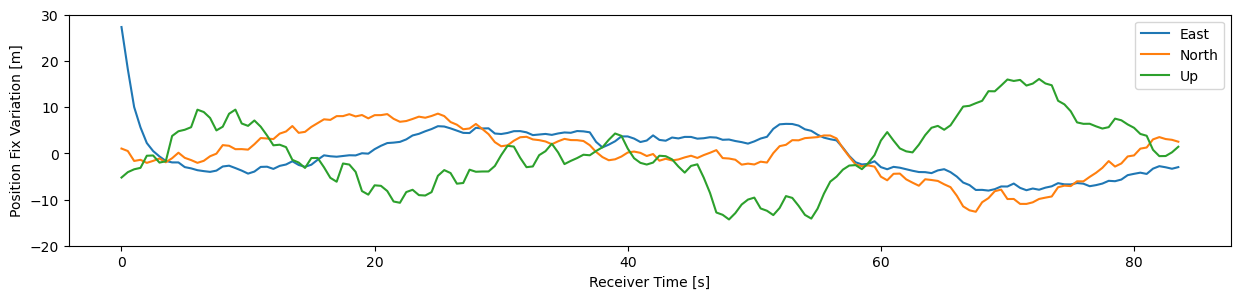

In [20]:
#| fig-cap: "Position fix variation from mean value, in local ENU coordinates."
#| label: fig-position-variation

delta = position_solution - np.mean(position_solution, axis=0)
delta = np.vstack([gpswt.coordinates.ecef_to_local(pt, 
                                             receive_pos_ellipsoid[0], 
                                             receive_pos_ellipsoid[1], 
                                            ) for pt in delta[:, 0:3]])
receiver_time = pseudo_ranges[best_prns[0]]['receive_time']

plt.figure(figsize=(15,3))
plt.plot(receiver_time, delta[:, 0], label='East')
plt.plot(receiver_time, delta[:, 1], label='North')
plt.plot(receiver_time, delta[:, 2], label='Up')
plt.ylabel('Position Fix Variation [m]')
plt.xlabel('Receiver Time [s]')
plt.ylim([-20,30])
plt.legend()
plt.show()

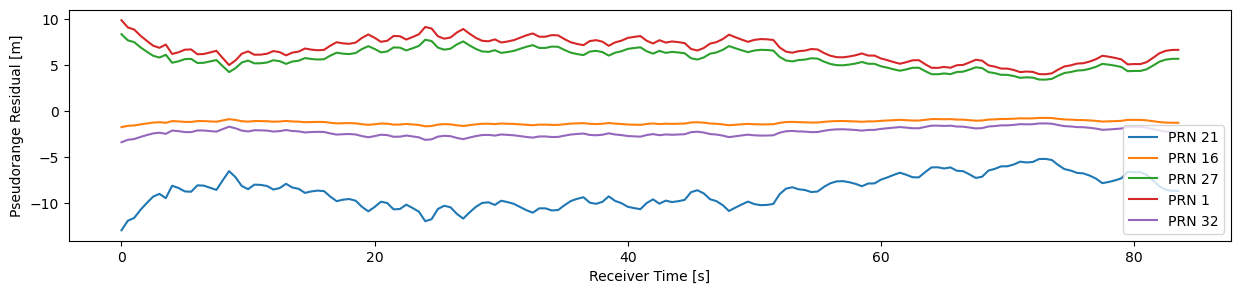

In [21]:
#| fig-cap: "Pseudorange residuals, i.e. not explained mismatch from model pseudorange at optimal position/time solution, for all satellites."
#| label: fig-prange-residuals

pseudo_range_errors = np.vstack([gpswt.pvt_solver._position_fix_error_function(x, ti, pseudo_ranges, satellite_positions) 
                                 for ti, x in enumerate(position_solution)])
plt.figure(figsize=(15,3))
for prn_index, prn in enumerate(best_prns):
    plt.plot(receiver_time, pseudo_range_errors[:, prn_index], label=f'PRN {prn}')
plt.ylabel('Pseudorange Residual [m]')
plt.xlabel('Receiver Time [s]')
plt.legend()
plt.show()

### Receiver Clock Analysis

In addition to the position, we also get a very accurate GPS time in the PVT solving process. With this we can analyze how accurate our clock is. As mentioned in Section 2, a Siglent function generator was used as a high-precision reference clock. The spec sheet reports a precision of better than $10^{-6}$, i.e. less than a microsecond off per second. Let's have a look wether that's true:

In [22]:
from scipy import stats

# bias = difference between receiver time and GPS time
clock_bias = receiver_time - position_solution[:, 3]
fit_bias = stats.linregress(receiver_time, clock_bias)

# a perfect receiver clock has slope = 1 s/s, but we get
print(f'Average clock drift: {(fit_bias.slope - 1) * 1e6:0.2f} microseconds/second')

Average clock drift: 0.50 microseconds/second


Indeed we find that the promise is hold, it is only slightly too fast. What about the long term stability? In @fig-clock-stability, we see slight variations of less than $\pm 0.5\mu s$ within 80 seconds recording period. The clock is rather stable.

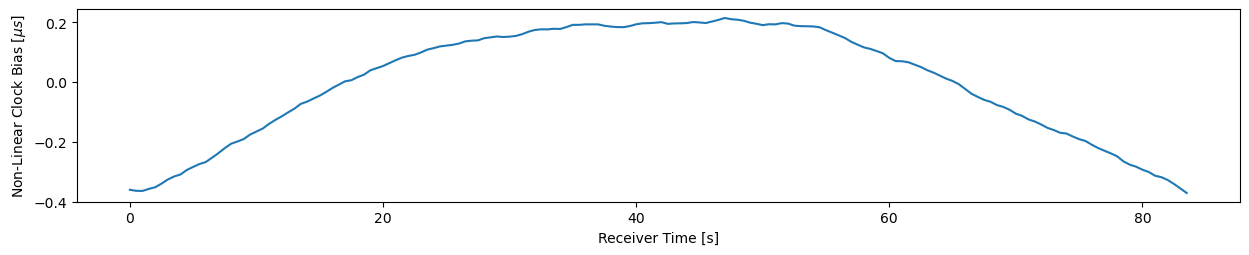

In [23]:
#| fig-cap: "Receiver clock stability. The clock bias is shown with its linear component (clock drift) removed."
#| label: fig-clock-stability

plt.figure(figsize=(15,2.5))
plt.plot(receiver_time, (clock_bias - receiver_time*fit_bias.slope - fit_bias.intercept) * 1e6)
plt.ylabel('Non-Linear Clock Bias [$\mu s$]')
plt.xlabel('Receiver Time [s]')
plt.show()

### Position and Satellite Visualization

To conclude, we visualize our location and satellites in @fig-visualize. Obviously we only see satellites which are above the horizon, i.e. a direct line of sight is not blocked by the earth.

And again, if you want to know more about PVT solving, then wait for the walkthrough step 8 to be published. In the meantime, have a look into the source code of the [PVT solver module](https://github.com/mu2718/gps-walkthrough/blob/main/gps_walkthrough/pvt_solver.py).

I hope you enjoyed the journey! Feel free to contact me and please leave your comments below. If you appreciated this article and you can afford it, how about to [buy me a coffee?](https://ko-fi.com/mu2718)

<script type='text/javascript' src='https://storage.ko-fi.com/cdn/widget/Widget_2.js'></script><script type='text/javascript'>kofiwidget2.init('Buy me a coffee', '#29abe0', 'E1E2S1R39');kofiwidget2.draw();</script> 
</br>

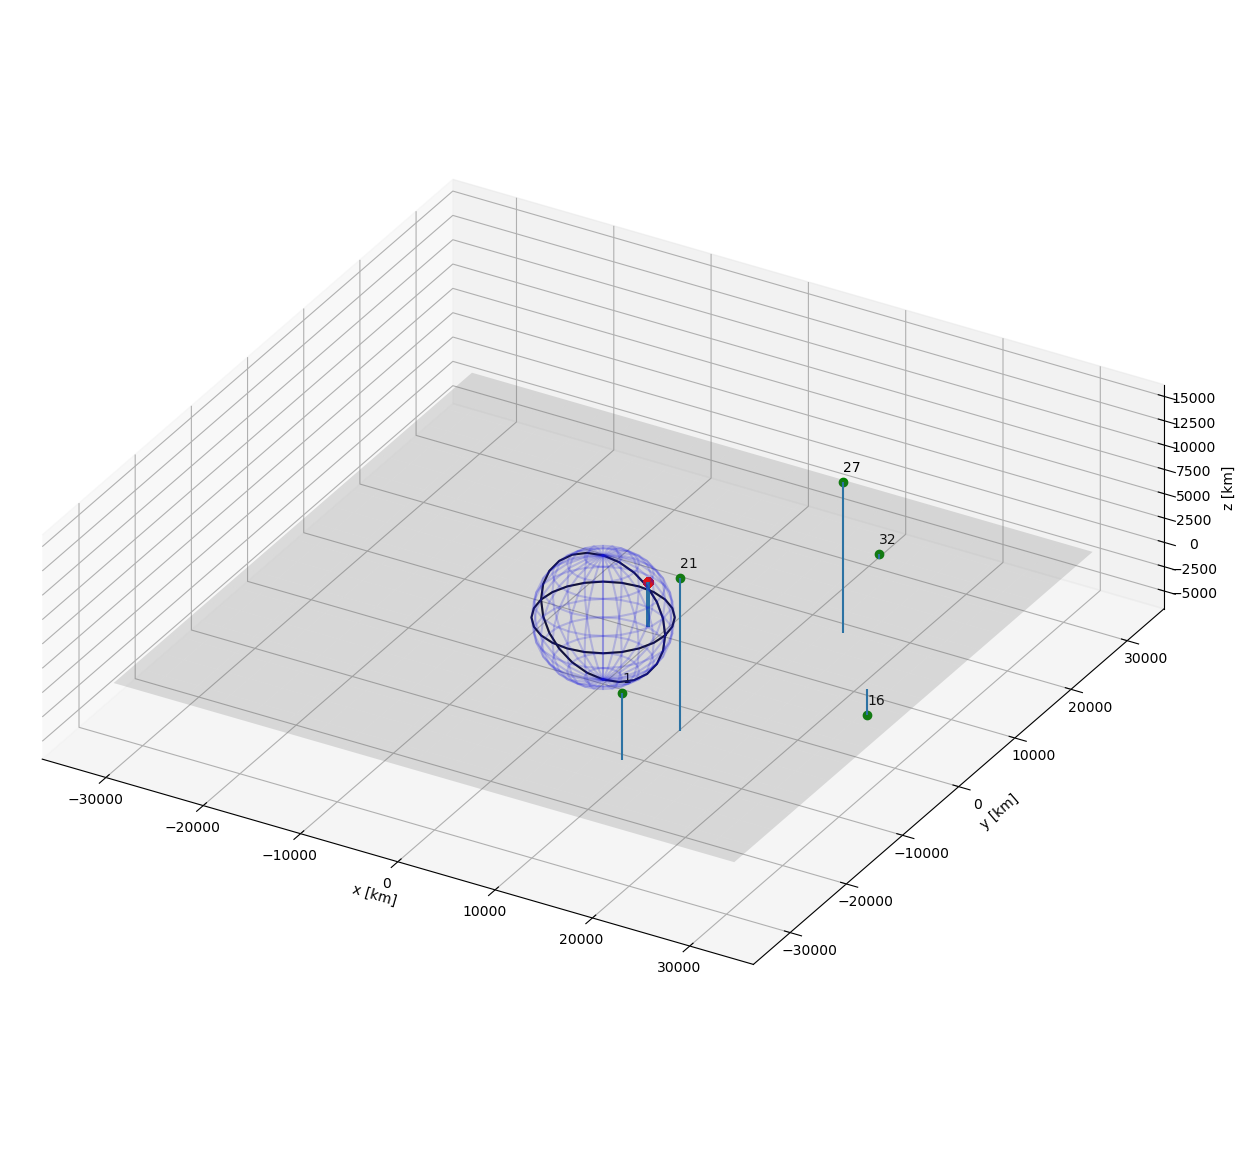

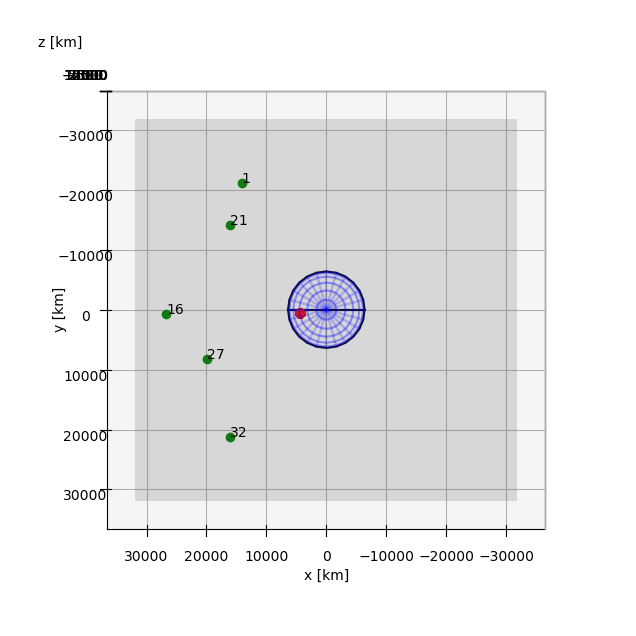

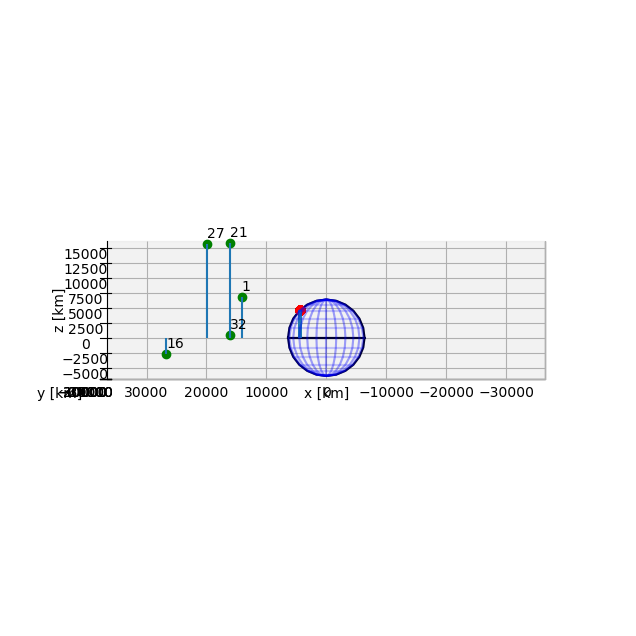

In [24]:
#| label: fig-visualize
#| column: screen
#| layout: [[100], [50,50]]
#| fig-cap: "Visualization of the geometric situation in a moment during the GPS radio wave recording."
#| fig-subcap: 
#|   - "Earth with indicated equator and prime meridian, our position (red), and satellites in WGS84 coordinate system. Stems are drawn from the equatorial plane (gray)."
#|   - "Top View."
#|   - "Side View."


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.set_proj_type('ortho')
    
# plot earth in spherical approximation
R = 6378137 / 1000 # [km] earth radius
u, v = np.meshgrid(np.linspace(0, 2*np.pi, 25),  # wireframe for every 15°
                   np.linspace(0, np.pi, 13)) 
x = R * np.cos(u) * np.sin(v)
y = R * np.sin(u) * np.sin(v)
z = R * np.cos(v)
ax.plot_wireframe(x, y, z, alpha=0.2, color='blue')

# add equator and null meridian
u = np.linspace(0,2*np.pi, 25)
ax.plot(R * np.cos(u), R*np.sin(u), 0*u, color='black')
ax.plot(R * np.cos(u), 0*u, R*np.sin(u), color='black')

# draw equatorial plane
x, y = np.meshgrid(np.linspace(-5*R, 5*R, 20), 
                   np.linspace(-5*R, 5*R, 20))
z = 0 * x
ax.plot_surface(x, y, z, alpha=0.2, color='gray')

# plot our position in red
ax.stem(*(position_solution[:, 0:3]/1000).transpose(), 
        markerfmt='or', bottom=0, orientation='z')

# plot satellites position
for prn in best_prns:    
    ax.stem(*(satellite_positions[prn][-2:-1]/1000).transpose(), 
            markerfmt='og', bottom=0, orientation='z')
    ax.text(*(satellite_positions[prn][-1]/1000 + [0,0,1000]), str(prn), None)

ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])  # set equal aspect ratio
ax.set_xlabel(('x [km]'))
ax.set_ylabel(('y [km]'))
ax.set_zlabel(('z [km]'))
plt.show()

plt.figure(fig)
ax.view_init(90,90)
fig.set_size_inches(8,8)
plt.show()

plt.figure(fig)
ax.view_init(0,90)
fig.set_size_inches(8,8)

## References {#sec-refs}

- [navipedia GPS L1 C/A](https://gssc.esa.int/navipedia/index.php/GPS_Signal_Plan#GPS_L1_Band)
- [Wikipedia GPS L1 C/A](https://en.wikipedia.org/wiki/GPS_signals#Legacy_GPS_signals)
- [gnss-sdr GPS L1 C/A](https://gnss-sdr.org/docs/tutorials/gnss-signals/#gps-l1)
- [gps.gov IS-GPS-200 GPS specification](https://www.gps.gov/technical/icwg/IS-GPS-200L.pdf) (PDF)
- [Calculating Position from Raw GPS Data](https://www.telesens.co/2017/07/17/calculating-position-from-raw-gps-data/), blog post by Ankur Mohan

See also more specific technical references in the source code of the [`gps_walkthrough` python module](https://github.com/mu2718/gps-walkthrough/).